# 📚 Necessary Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.serialization
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import time
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 8)

2025-05-16 11:28:22.617947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747394902.815084      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747394902.873579      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#  🧪 Dataset Preprocessing & Train-Test Split

In [ ]:
# Seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# DEVICE setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

file_path = '/kaggle/input/articles/positive_negative_articles.csv'
articles = pd.read_csv(file_path)

Using device: cuda


In [ ]:
# Drop missing abstracts
articles = articles.dropna(subset=['abstract'])
print(f"Shape after dropping NaN abstracts: {articles.shape}")

# Check and balance classes
print("Original class distribution:")
print(articles['labels'].value_counts())

min_class_count = min(articles['labels'].value_counts())
balanced_df = pd.concat([
    articles[articles['labels'] == 1].sample(min_class_count, random_state=42),
    articles[articles['labels'] == 0].sample(min_class_count, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

print("\nBalanced class distribution:")
print(balanced_df['labels'].value_counts())

# Train-test split
train_df, test_df = train_test_split(balanced_df, test_size=0.2, stratify=balanced_df['labels'], random_state=42)

Shape after dropping NaN abstracts: (2107, 5)
Original class distribution:
labels
0    1190
1     917
Name: count, dtype: int64

Balanced class distribution:
labels
1    917
0    917
Name: count, dtype: int64


# ⚙️ Tokenization & Model Configuration

In [ ]:
# Custom Class that prepares text `abstracts` and `labels` to be fed into a PyTorch model
class AbstractDataset(Dataset):
    def __init__(self, abstracts, labels, tokenizer, max_length):
        self.abstracts = abstracts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.abstracts)

    def __getitem__(self, idx):
        abstract = str(self.abstracts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            abstract,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
MAX_LEN = 256
BATCH_SIZE = 32

train_dataset = AbstractDataset(train_df['abstract'].tolist(), train_df['labels'].tolist(), tokenizer, MAX_LEN)
val_dataset = AbstractDataset(test_df['abstract'].tolist(), test_df['labels'].tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.05)
EPOCHS = 10
total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    correct = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct += torch.sum(preds == labels)
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct.double() / len(data_loader.dataset), total_loss / len(data_loader)

In [ ]:
def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct += torch.sum(preds == labels)
            total_loss += loss.item()

    return correct.double() / len(data_loader.dataset), total_loss / len(data_loader)

In [ ]:
best_val_acc = 0.0
save_path = "/kaggle/working/best_model_full.pt"

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print('-' * 10)

    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler)
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')

    val_acc, val_loss = eval_model(model, val_loader, loss_fn, device)
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    # Save model if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, save_path)
        print(f"Best model saved at: {save_path}")


Epoch 1/10
----------
Train Loss: 0.5396, Train Accuracy: 0.7232
Val Loss: 0.2974, Val Accuracy: 0.8665
Best model saved at: /kaggle/working/best_model_full.pt

Epoch 2/10
----------
Train Loss: 0.2526, Train Accuracy: 0.8984
Val Loss: 0.2156, Val Accuracy: 0.9019
Best model saved at: /kaggle/working/best_model_full.pt

Epoch 3/10
----------
Train Loss: 0.1603, Train Accuracy: 0.9407
Val Loss: 0.2056, Val Accuracy: 0.9046
Best model saved at: /kaggle/working/best_model_full.pt

Epoch 4/10
----------
Train Loss: 0.1150, Train Accuracy: 0.9598
Val Loss: 0.2134, Val Accuracy: 0.9210
Best model saved at: /kaggle/working/best_model_full.pt

Epoch 5/10
----------
Train Loss: 0.0732, Train Accuracy: 0.9734
Val Loss: 0.2212, Val Accuracy: 0.9155

Epoch 6/10
----------
Train Loss: 0.0537, Train Accuracy: 0.9864
Val Loss: 0.2378, Val Accuracy: 0.9237
Best model saved at: /kaggle/working/best_model_full.pt

Epoch 7/10
----------
Train Loss: 0.0387, Train Accuracy: 0.9925
Val Loss: 0.2641, Val Ac

# 🔍 Inspecting Model Results

In [ ]:
def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []
    probs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probabilities = torch.softmax(logits, dim=1)
            preds = torch.argmax(probabilities, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            probs.extend(probabilities[:, 1].cpu().numpy())

    return np.array(predictions), np.array(true_labels), np.array(probs)


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       184
           1       0.91      0.95      0.93       183

    accuracy                           0.93       367
   macro avg       0.93      0.93      0.93       367
weighted avg       0.93      0.93      0.93       367



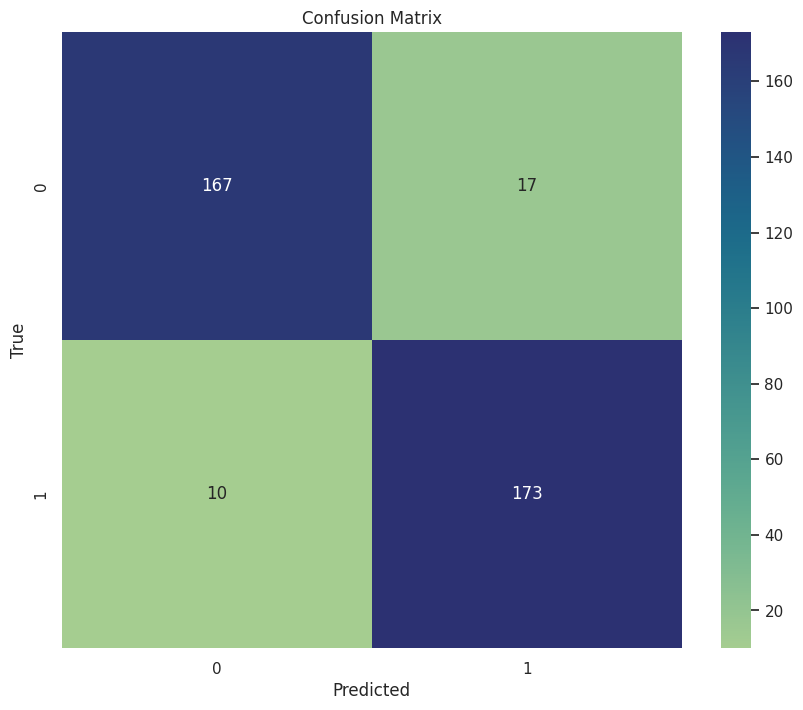

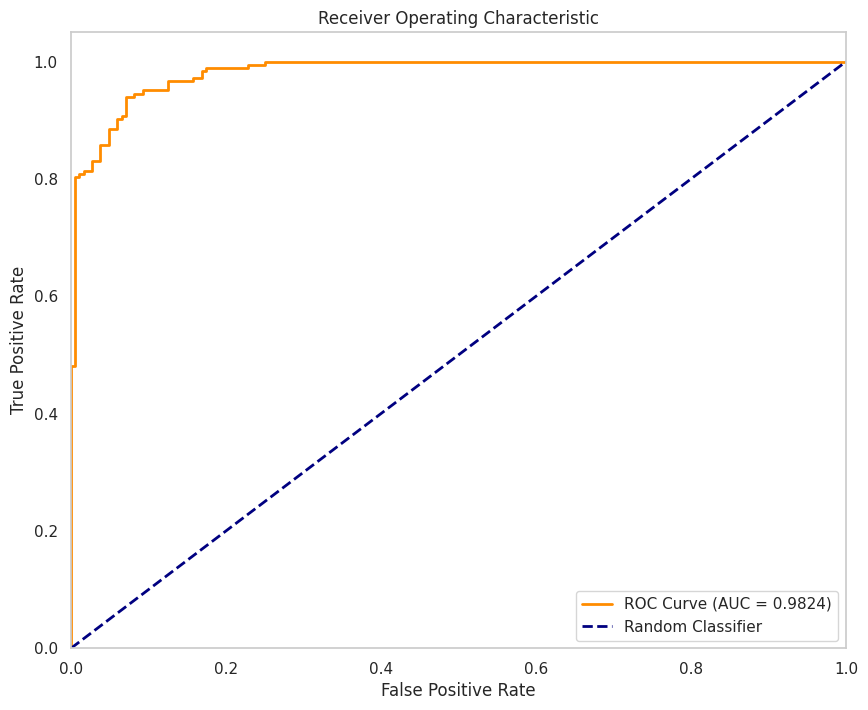

In [ ]:
# Get predictions on validation set
y_pred, y_true, y_prob = get_predictions(model, val_loader)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=2))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='crest', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# 💡 Most influential words

In [ ]:
torch.serialization.add_safe_globals([DistilBertForSequenceClassification])
model = torch.load("/kaggle/working/best_model_full.pt", map_location=device, weights_only=False)
model = model.to(device)
model.eval()

def visualize_token_importance(text, model, tokenizer, device, true_label=None, idx=None):
    model.eval()

    # Tokenize input
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=256, return_attention_mask=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Get input embeddings and enable gradient tracking
    embeddings = model.distilbert.embeddings(input_ids)
    embeddings.retain_grad()

    # Forward pass using embeddings
    outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask)
    logits = outputs.logits
    pred_label = logits.argmax(dim=1).item()

    # Backward pass
    score = logits[:, pred_label]
    score.backward()

    # Get gradients w.r.t. embeddings
    grads = embeddings.grad.abs().sum(dim=-1).squeeze().detach().cpu().numpy()
    grads = grads ** 0.5
    grads = (grads - grads.min()) / (grads.max() - grads.min() + 1e-10)

    # Convert token IDs to strings
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())

    # Visualize with colors
    def color_word(token, score):
        cmap = get_cmap('coolwarm')
        rgba = cmap(score)
        color = mcolors.rgb2hex(rgba[:3])
        return f'<span style="background-color:{color}; padding:2px; margin:1px; border-radius:4px;">{token}</span>'

    colored_text = " ".join([color_word(t, s) for t, s in zip(tokens, grads)])

    header = f"<div style='margin-top:20px; margin-bottom:5px; font-weight:bold;'>Example #{idx if idx is not None else '?'} | True label: {true_label} | Predicted label: {pred_label}</div>"
    display(HTML(header + f"<div style='font-family:monospace; line-height:1.6; font-size: 16px;'>{colored_text}</div>"))

# Visualize 10 random abstracts
sampled_df = test_df.sample(n=10).reset_index()

for i in range(len(sampled_df)):
    text = sampled_df.loc[i, 'abstract']
    label = sampled_df.loc[i, 'labels']
    visualize_token_importance(text, model, tokenizer, device, true_label=label, idx=sampled_df.loc[i, 'index'])